In [26]:
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from scipy.io import readsav
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Filename: /content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/s000.ImagingSpectralScan_8542.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      33   ()      
  1                1 ImageHDU        56   (1000, 1000)   int16   
  2                1 ImageHDU        56   (1000, 1000)   int16   
  3                1 ImageHDU        56   (1000, 1000)   int16   
  4                1 ImageHDU        56   (1000, 1000)   int16   
  5                1 ImageHDU        56   (1000, 1000)   int16   
  6                1 ImageHDU        56   (1000, 1000)   int16   
  7                1 ImageHDU        56   (1000, 1000)   int16   
  8                1 ImageHDU        56   (1000, 1000)   int16   
  9                1 ImageHDU        56   (1000, 1000)   int16   
 10                1 ImageHDU        56   (1000, 1000)   int16   
 11                1 ImageHDU        56   (1000, 1000)   int16   
 12                1 ImageHDU        56   (1000, 1000)   int

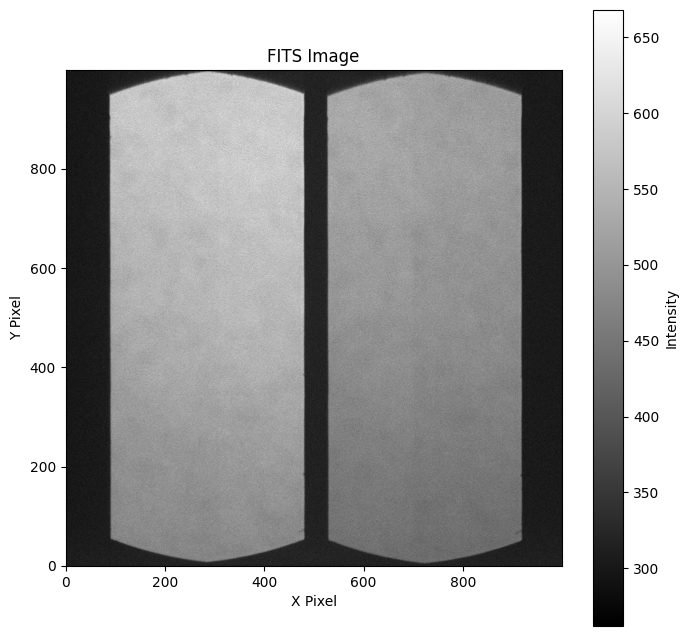

In [27]:


fits_files = glob.glob("/content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/*8542.fits")
# Check if FITS files exist
if fits_files:
    # Open the first FITS file
    with fits.open(fits_files[0]) as hdul:
        hdul.info()  # Print summary of HDU list

        # Access primary data
        image_data = hdul[1].data
        header = hdul[1].header          #should we do that for all the hdul?

        # Print header and data shape
        # print(header)
        if image_data is not None:
            # print(f"Data shape: {image_data.shape}")

            # Plot the image data
            plt.figure(figsize=(8, 8))
            plt.imshow(image_data, cmap='gray', origin='lower')
            plt.colorbar(label='Intensity')
            plt.title('FITS Image')
            plt.xlabel('X Pixel')
            plt.ylabel('Y Pixel')
            plt.show()
        else:
            print("No data found in the primary HDU.")
else:
    print("No FITS files found in the directory.")

<function matplotlib.pyplot.colorbar(mappable: 'ScalarMappable | ColorizingArtist | None' = None, cax: 'matplotlib.axes.Axes | None' = None, ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None, **kwargs) -> 'Colorbar'>

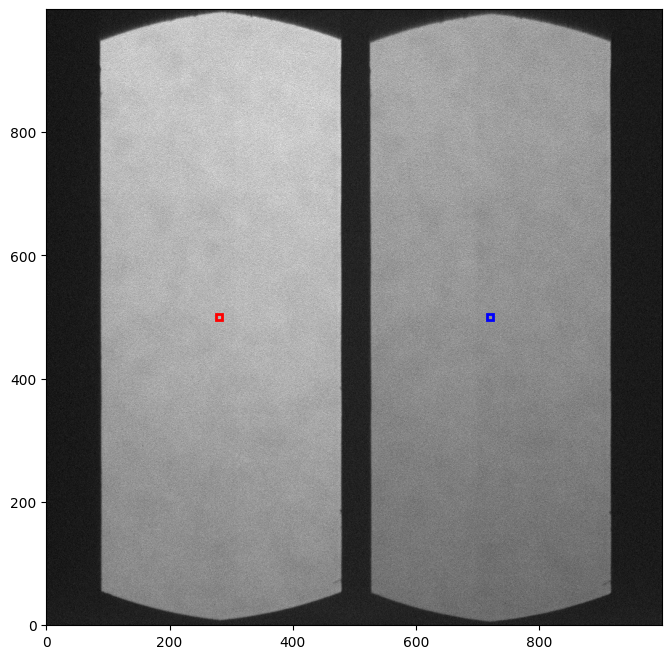

In [28]:

# Parametri per le due regioni
half_size = 5  # Metà della dimensione delle regioni (50x50)

# Ottieni le dimensioni dell'immagine
image_height, image_width = image_data.shape

# Centro in y (metà dell'altezza dell'immagine)
y_center = image_height // 2

# Regione 1 (x centrato a metà larghezza - 220)
x_center_1 = image_width // 2 - 220
x_start_1 = x_center_1 - half_size
x_end_1 = x_center_1 + half_size

# Regione 2 (x centrato a metà larghezza + 220)
x_center_2 = image_width // 2 + 220
x_start_2 = x_center_2 - half_size
x_end_2 = x_center_2 + half_size

# Calcolo degli indici y (comuni ad entrambe le regioni)
y_start = y_center - half_size
y_end = y_center + half_size

# Ora hai le coordinate per entrambe le regioni:
# Regione 1: (x_start_1, y_start) a (x_end_1, y_end)
# Regione 2: (x_start_2, y_start) a (x_end_2, y_end)

# Plot con rettangolo evidenziato
plt.figure(figsize=(10, 8))
plt.imshow(image_data, cmap='gray', origin='lower')

# Aggiungi rettangolo rosso per la regione 1
rect1 = Rectangle((x_start_1, y_start),
                    width=2*half_size,
                    height=2*half_size,
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none')
plt.gca().add_patch(rect1)

# Aggiungi rettangolo blu per la regione 2
rect2 = Rectangle((x_start_2, y_start),
                    width=2*half_size,
                    height=2*half_size,
                    linewidth=2,
                    edgecolor='b',
                    facecolor='none')
plt.gca().add_patch(rect2)

plt.colorbar

In [29]:
if fits_files:
    with fits.open(fits_files[0]) as hdul:
        # Lista per salvare le regioni centrali di tutte le HDUs
        central_regions = []

        # Iteriamo su tutte le HDUs (escludendo la PRIMARY HDU)
        for hdu in hdul[1:]:
            data = hdu.data
            if data is not None:
                # Estraiamo le due regioni
                region_1 = data[y_start:y_end, x_start_1:x_end_1]
                region_2 = data[y_start:y_end, x_start_2:x_end_2]

                # Calcoliamo la media delle due regioni
                central_region = np.mean([region_1, region_2])

                central_regions.append(central_region)

central_regions = central_regions / np.max(central_regions)

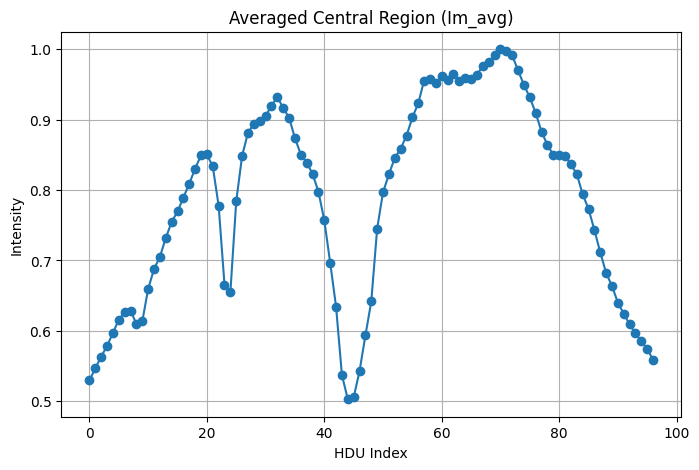

In [30]:

plt.figure(figsize=(8, 5))
plt.plot(central_regions, marker='o', linestyle='-')
plt.title('Averaged Central Region (Im_avg)')
plt.xlabel('HDU Index')
plt.ylabel('Intensity')
plt.grid(True)
plt.show()


In [31]:



file_pattern = "/content/drive/MyDrive/IBIS_SWG/input/prefilter/*8542*.sav"
file_list = glob.glob(file_pattern)

if not file_list:
    print("No files found matching the pattern.")
else:
    for file_path in file_list:
        try:
            prefilter = readsav(file_path)
            print(f"Successfully read: {file_path}")
            # `data` is a dictionary-like object containing variables
        except Exception as e:
            print(f"Error reading {file_path}: {e}")




Successfully read: /content/drive/MyDrive/IBIS_SWG/input/prefilter/prefilter.8542.reference.profile.Apr2015.sav


In [32]:
prefilter.keys()

dict_keys(['prefilt8542_ref_wvscl', 'prefilt8542_ref_main', 'prefilt8542_fringe', 'prefilt8542_ref_interval', 'prefilt8542_ref_source'])

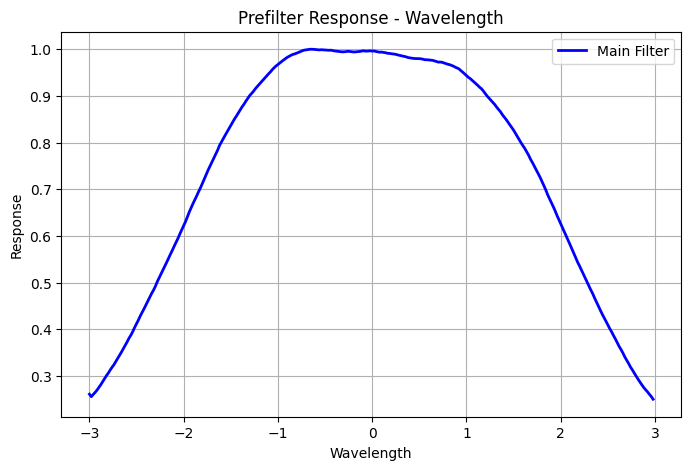

In [33]:

# Extract data
wavelengths = prefilter['prefilt8542_ref_wvscl']  # X-axis (wavelength scale)
main_filter = prefilter['prefilt8542_ref_main']   # Y-axis (main filter response)
fringe_filter = prefilter['prefilt8542_fringe']  # Y-axis (fringe response)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, main_filter, label="Main Filter", color='b', linewidth=2)


# Labels and title
plt.xlabel("Wavelength")
plt.ylabel("Response")
plt.title("Prefilter Response - Wavelength")
plt.legend()
plt.grid()

# Show plot
plt.show()


Dimensione di Im_p: (97,)


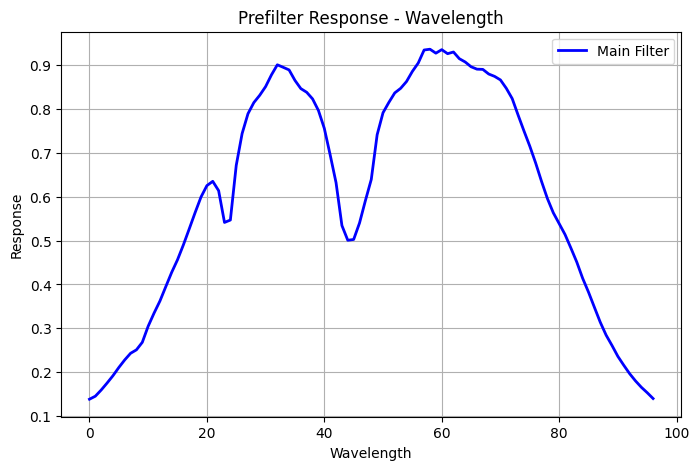

In [34]:
# Creiamo una nuova griglia con 97 punti (come central_regions)
new_x = np.linspace(0, 1, 97)  # Griglia ridotta
old_x = np.linspace(0, 1, 300)  # Griglia originale

# Interpoliamo i valori di main_filter sulla nuova griglia
main_filter_resampled = np.interp(new_x, old_x, main_filter)

# Ora i due array sono compatibili
Im_p = central_regions * main_filter_resampled

print(f"Dimensione di Im_p: {Im_p.shape}")  # Deve restituire (97,)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(Im_p, label="Main Filter", color='b', linewidth=2)


# Labels and title
plt.xlabel("Wavelength")
plt.ylabel("Response")
plt.title("Prefilter Response - Wavelength")
plt.legend()
plt.grid()

# Show plot
plt.show()

Dimensione di Im_p: (300,)


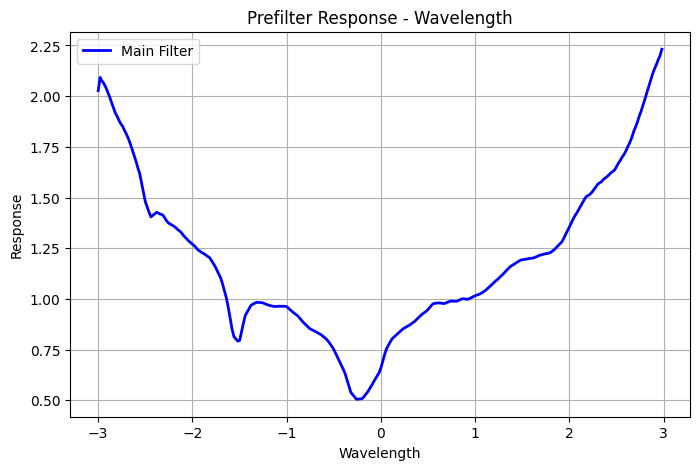

In [35]:
old_x = np.linspace(0, 1, 97)  # Griglia originale
new_x = np.linspace(0, 1, 300)  # Griglia

# Interpoliamo i valori di main_filter sulla nuova griglia
central_regions_resampled = np.interp(new_x, old_x, central_regions)

# Ora i due array sono compatibili
Im_p = central_regions_resampled / main_filter

print(f"Dimensione di Im_p: {Im_p.shape}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, Im_p, label="Main Filter", color='b', linewidth=2)


# Labels and title
plt.xlabel("Wavelength")
plt.ylabel("Response")
plt.title("Prefilter Response - Wavelength")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [36]:


# Find the index of the minimum value.
min_index = np.argmin(Im_p)

# Print the index of the minimum value.
print(min_index)

min_wave_obs= wavelengths[min_index]
print(min_wave_obs)



137
-0.26


In [37]:


def read_jung_fits(file, w1, w2, subsample=1):
    """
    Reads the Jungfraujoch solar spectrum from a FITS file.

    Parameters:
    - file: str, path to the FITS file.
    - w1: int, starting wavelength (Å).
    - w2: int, ending wavelength (Å).
    - subsample: int, optional, subsampling factor (default=1).

    Returns:
    - wave: numpy array, wavelength array.
    - sp: numpy array, spectral intensities.
    """

    # --- Help message ---
    if w1 is None or w2 is None:
        print("Usage: read_jung_fits(file, w1, w2, subsample=ss)")
        print("Wavelength limits: 3601 to 9300 Å")
        print("Subsample should be in {1,2,4,5,10,20,50,100,250,500}")
        return

    # --- Check inputs ---
    if w1 < 3601:
        raise ValueError(f"Error: Min wavelength is 3601 Å. Given: {w1}")
    if w2 > 9300:
        raise ValueError(f"Error: Max wavelength is 9300 Å. Given: {w2}")
    if w2 < w1:
        raise ValueError("Error: Max wavelength is smaller than min wavelength")

    # --- Calculate byte skip ---
    skip = round((w1 - 3601) * 1000)    # 2880 is the FITS header size

    np_points = (w2 - w1 + 1) * 500  # 500 points per Angstrom

    # --- Open the FITS file and read the data ---
    with fits.open(file, memmap=True) as hdul:
        raw_data = hdul[0].data
        header = hdul[0].header

    # --- Extract the portion of interest ---
    sp = raw_data.flatten()[skip // 2: skip // 2 + np_points]

    # # --- Byte order correction (like IDL's `byteorder`) ---
    if sp.dtype.byteorder != '=':  # Native byte order
        sp = sp.byteswap().newbyteorder()

    # --- Convert from int16 to float and scale ---
    sp = sp.astype(np.float32) * 0.1

    # --- Apply subsampling if needed ---
    if subsample > 1:
        sp = sp.reshape(-1, subsample).mean(axis=1)

    # --- Create wavelength array ---
    wave = np.arange(len(sp), dtype=np.float32) * 0.002 * subsample + w1

    return wave, sp


8544.998


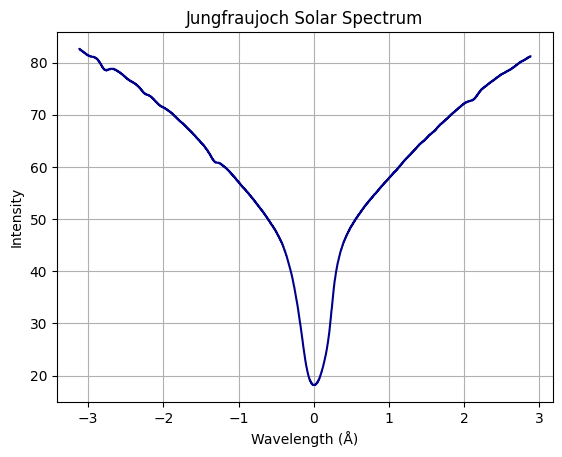

In [38]:
# File path
file = '/content/drive/MyDrive/IBIS_SWG/input/atlas/jun.fits'

wave, spectrum = read_jung_fits(file, w1=8539, w2=8544)

# Plot the spectrum
# wave_corrected = wave - 3.0
print(wave[-1])

plt.plot(wave-8542.116, spectrum, color="darkblue")
plt.title("Jungfraujoch Solar Spectrum")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensity")
plt.grid(True)
plt.savefig('/content/drive/MyDrive/IBIS_SWG/output/jungfraujoch_spectrum.png') # Save the plot
plt.show()


In [39]:
wave[-1]

8544.998